In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


# skopt imports
from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV

# distributions we'll need
from scipy.stats import uniform, loguniform

# regex
import re

# text preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import time 

## Cleaning

Using the scraped data that we saved, we're going to check for any nulls that happened to pass through and remove them.

In [2]:
nosleep = pd.read_csv('./data/nosleep.csv')
tale = pd.read_csv('./data/idontworkherelady.csv')

In [3]:
# tokenizing function
def tokenize(column):
    return word_tokenize(column)

In [4]:
nosleep.tail()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
10022,The Balloon Man,There’s a man with a handful of balloons at th...,nosleep,1589810985,Pie-rate_Pear-rot,3,1,True,2020-05-18
10023,The house i grew up in / part 1,"I don’t remember much of my childhood, I was 5...",nosleep,1589811196,Benisman12,2,1,True,2020-05-18
10024,The Other Side,"There’s a small town, and in the middle of tha...",nosleep,1589812475,PalkiaDots25,0,1,True,2020-05-18
10025,A strange box appeared on my front door .i can...,"My childhood wasn’t what you would call ,norma...",nosleep,1589813624,potatoman-177,2,1,True,2020-05-18
10026,Honey,She smiled at him. A smile is worth many thing...,nosleep,1589815336,grajmanu,2,1,True,2020-05-18


In [5]:
nosleep.isnull().sum()

title           0
selftext        2
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
dtype: int64

In [6]:
tale.isnull().sum()

title           0
selftext        9
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
dtype: int64

In [7]:
tale[tale['selftext'].isnull()]

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
4383,Another short but wholesome IDWHL story in Box...,NaN,IDontWorkHereLady,1575360422,TKmeh,0,1,True,2019-12-03
4502,What if everyone wore custom T-shirt’s that re...,NaN,IDontWorkHereLady,1573882959,RoyalKyn,0,1,True,2019-11-15
4580,I’m,NaN,IDontWorkHereLady,1573704247,eva_white,1,1,True,2019-11-13
4930,"Someone needs to make ""I Don't Work Here"" shirts.",NaN,IDontWorkHereLady,1569995945,NJM15642002,0,1,True,2019-10-01
6722,[Meta] Take off your apron,NaN,IDontWorkHereLady,1555142170,hurryupand_wait,0,1,True,2019-04-13
6746,Found on Imgur. Just thought it would be good ...,NaN,IDontWorkHereLady,1554437152,Mkitty760,0,1,True,2019-04-04
8273,If you walk through a department store wearing...,NaN,IDontWorkHereLady,1545009303,ro_ok,0,1,True,2018-12-16
8793,Reading these stories makes me want to dress a...,NaN,IDontWorkHereLady,1541620498,drinkKing,7,1,True,2018-11-07
9580,Entitled idiot decides to moan and complain in...,NaN,IDontWorkHereLady,1534386928,IdiotRetailCustomers,0,1,True,2018-08-15


In [8]:
nosleep[nosleep['selftext'].isnull()]

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
9596,What Marijuana Strains Work Best for Sleep?,NaN,nosleep,1591095495,CurtD34,1,1,True,2020-06-02
9800,I found a box of strange DVDs at work. I wish ...,NaN,nosleep,1590295783,BillyManHansJr,1,1,True,2020-05-23


In [9]:
tale.dropna(inplace = True)
nosleep.dropna(inplace = True)

We'll then remove about half of our scraped data from each subreddit, as we believe a total of 10,000 posts combined is more than enough data to model. Any cleaning left is for removing links, punctuation, and any markdown features that will interfere with tokenizing.

In [10]:
nosleep = nosleep[:5100]
tale = tale[:5100]

In [11]:
# removes links
tale['title'] = [re.sub(r'http\S+', '', text) for text in tale['title']]
tale['selftext'] = [re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) for text in tale['selftext']]
# removes special characters
tale['title'] = [re.sub(r'[^\w\s]', '', text) for text in tale['title']]
# removes all punctuation
tale['title'] = [re.sub("(?<=[a-z])'(?=[a-z])", "", text) for text in tale['title']]

# removes links
tale['selftext'] = [re.sub(r'http\S+', '', text) for text in tale['selftext']]
# removes special characters
tale['selftext'] = [re.sub(r'[^\w\s]', '', text) for text in tale['selftext']]
# removes all punctuation
tale['selftext'] = [re.sub("(?<=[a-z])'(?=[a-z])", "", text) for text in tale['selftext']]

In [12]:
# removes links
nosleep['title'] = [re.sub(r'http\S+', '', text) for text in nosleep['title']]
nosleep['selftext'] = [re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) for text in nosleep['selftext']]
# removes special characters
nosleep['title'] = [re.sub(r'[^\w\s]', '', text) for text in nosleep['title']]
# removes all punctuation
nosleep['title'] = [re.sub("(?<=[a-z])'(?=[a-z])", "", text) for text in nosleep['title']]

# removes links
nosleep['selftext'] = [re.sub(r'http\S+', '', text) for text in nosleep['selftext']]
# removes special characters
nosleep['selftext'] = [re.sub(r'[^\w\s]', '', text) for text in nosleep['selftext']]
# removes all punctuation
nosleep['selftext'] = [re.sub("(?<=[a-z])'(?=[a-z])", "", text) for text in nosleep['selftext']]

In [13]:
# Remove certain reddit markdown issues from title and selftext column
# function credit: https://github.com/gwenrathgeber/subreddit_text_classification/blob/master/code/clean_raw_data.py
for column in ['title','selftext']:
    tale[column] = tale[column].str.replace('\xa0',' ')
    tale[column] = tale[column].str.replace('&lt;',' ')
    tale[column] = tale[column].str.replace('&gt;',' ')
    tale[column] = tale[column].str.replace('&amp;',' ')
    tale[column] = tale[column].str.replace('x200B','')
    tale.loc[:,column] = tale[column].str.replace('\n',' ')

In [14]:
# Remove certain reddit markdown issues from title and selftext column
# function credit: https://github.com/gwenrathgeber/subreddit_text_classification/blob/master/code/clean_raw_data.py
for column in ['title','selftext']:
    nosleep[column] = nosleep[column].str.replace('\xa0',' ')
    nosleep[column] = nosleep[column].str.replace('&lt;',' ')
    nosleep[column] = nosleep[column].str.replace('&gt;',' ')
    nosleep[column] = nosleep[column].str.replace('&amp;',' ')
    nosleep[column] = nosleep[column].str.replace('x200B','')
    nosleep.loc[:,column] = nosleep[column].str.replace('\n',' ')

Now we're dropping columns that are not either the title or the selftext, and binarizing the subreddit column.

In [15]:
nosleep.drop(columns = ['created_utc', 'author', 'num_comments', 'score', 'is_self', 'timestamp'], inplace = True)

In [16]:
tale.drop(columns = ['created_utc', 'author', 'num_comments', 'score', 'is_self', 'timestamp'], inplace = True)

In [17]:
nosleep.reset_index(drop = True)
tale.reset_index(drop = True)

,title,selftext,subreddit
0,Thats not my job,Tonight I visited my old stomping grounds I us...,IDontWorkHereLady
1,Just because I put stuff back into the shelf d...,The other day I was at our local drugstore I c...,IDontWorkHereLady
2,Im not sure you should be shopping unsupervised,This happened to me yesterday and is a little ...,IDontWorkHereLady
3,You dont work here but would you like to,Many years ago I worked for Home Depot as a lu...,IDontWorkHereLady
4,You must be new in town,I was in the grocery store and had a basket wi...,IDontWorkHereLady
...,...,...,...
5095,I almost had an I dont work here lady moment,So I know that I didnt really have an experien...,IDontWorkHereLady
5096,Im not a doctor Im a sales agent,Disclaimer its been so long since I last had a...,IDontWorkHereLady
5097,Entitled Woman at Universal Studios Japan,I am a 24 year old female working in Osaka Ja...,IDontWorkHereLady
5098,I dont think I want a tattoo anymore,So I wanted a tattoo for a while now but I ALW...,IDontWorkHereLady


We're tokenizing the title and selftext of both subreddits.

In [18]:
nosleep['toke_selftext'] = nosleep.apply(lambda row: word_tokenize(row['selftext']), axis=1)

In [19]:
nosleep['toke_title'] = nosleep.apply(lambda row: word_tokenize(row['title']), axis=1)

In [20]:
tale['toke_selftext'] = tale.apply(lambda row: word_tokenize(row['selftext']), axis=1)
tale['toke_title'] = tale.apply(lambda row: word_tokenize(row['title']), axis=1)

In [21]:
sleep = nosleep.drop(columns = ['title', 'selftext'])
sleep.head()

,subreddit,toke_selftext,toke_title
0,nosleep,"[The, Leatherman, was, local, folklore, virtua...","[The, Leatherman]"
1,nosleep,"[As, a, forensic, cleaner, there, are, many, t...","[That, Thing]"
2,nosleep,"[I, had, just, woke, up, in, the, middle, of, ...",[Smile]
3,nosleep,"[Hello, its, Renee, again, Im, really, sorry, ...","[I, made, a, list, ranking, my, neighbours, Ki..."
4,nosleep,"[Part, I, linked, here, So, its, been, a, whil...","[What, I, did, in, my, past, could, cost, me, ..."


Once tokenized, we're now lemmatizing the text to reduce words to their basic meaning. No stemming is done as we believe it to be too brutal and would cause us to lose nuance of the posts. Subreddit titles will be combined with selftext to reduce any complexity in lemmatizing. We will then add both subreddits together into one combined dataframe.

In [22]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [23]:
# lemmatize columns
sleep['lem_title'] = sleep['toke_title'].apply(lemmatize_text)
sleep['lem_selftext'] = sleep['toke_selftext'].apply(lemmatize_text)
# rejoin list as string
sleep['lem_title'] = sleep['lem_title'].apply(lambda x: ','.join(map(str, x))).str.replace(',', ' ')
sleep['lem_selftext'] = sleep['toke_selftext'].apply(lambda x: ','.join(map(str, x))).str.replace(',', ' ')

sleep.drop(columns = ['toke_selftext', 'toke_title'], inplace = True)

In [24]:
# combining title and selftext
sleep['fulltext'] = sleep['lem_title'] + ' ' + sleep['lem_selftext']
sleep.drop(columns = ['lem_title', 'lem_selftext'], inplace = True)

In [26]:
# lemmatize columns
tale['lem_title'] = tale['toke_title'].apply(lemmatize_text)
tale['lem_selftext'] = tale['toke_selftext'].apply(lemmatize_text)
# rejoin list as string
tale['lem_title'] = tale['lem_title'].apply(lambda x: ','.join(map(str, x))).str.replace(',', ' ')
tale['lem_selftext'] = tale['toke_selftext'].apply(lambda x: ','.join(map(str, x))).str.replace(',', ' ')

tale.drop(columns = ['toke_selftext', 'toke_title', 'title', 'selftext'], inplace = True)

In [27]:
# combining title and selftext
tale['fulltext'] = tale['lem_title'] + ' ' + tale['lem_selftext']
tale.drop(columns = ['lem_title', 'lem_selftext'], inplace = True)

In [28]:
# concat both subreddits together into one dataframe
both = pd.concat([sleep, tale])

In [29]:
# reset index for later computation
both.reset_index(drop = True)

,subreddit,fulltext
0,nosleep,The Leatherman The Leatherman was local folklo...
1,nosleep,That Thing As a forensic cleaner there are man...
2,nosleep,Smile I had just woke up in the middle of the ...
3,nosleep,I made a list ranking my neighbour Kids these ...
4,nosleep,What I did in my past could cost me everything...
...,...,...
10195,IDontWorkHereLady,I almost had an I dont work here lady moment S...
10196,IDontWorkHereLady,Im not a doctor Im a sale agent Disclaimer its...
10197,IDontWorkHereLady,Entitled Woman at Universal Studios Japan I am...
10198,IDontWorkHereLady,I dont think I want a tattoo anymore So I want...


In [30]:
both['subreddit'] = both['subreddit'].map(lambda x: 1 if x == 'nosleep' else 0)

In [31]:
both.reset_index(drop = True)

,subreddit,fulltext
0,1,The Leatherman The Leatherman was local folklo...
1,1,That Thing As a forensic cleaner there are man...
2,1,Smile I had just woke up in the middle of the ...
3,1,I made a list ranking my neighbour Kids these ...
4,1,What I did in my past could cost me everything...
...,...,...
10195,0,I almost had an I dont work here lady moment S...
10196,0,Im not a doctor Im a sale agent Disclaimer its...
10197,0,Entitled Woman at Universal Studios Japan I am...
10198,0,I dont think I want a tattoo anymore So I want...


## EDA

We will examine the most popular words of both subreddits to get an idea of what to expect before we model.

In [33]:
cv2 = CountVectorizer(stop_words= 'english',
                        max_df=.98,
                        max_features = 3000,
                        min_df = 5,
                        ngram_range = (1,2))

sleep_vec = cv2.fit_transform(sleep['fulltext'])
vec_sleep = pd.DataFrame(sleep_vec.toarray(), columns = cv2.get_feature_names())

In [34]:
slp = vec_sleep.mean().sort_values(ascending = False)

r/NoSleep contains many words that are literary and more figurative in nature. This is to be expected as the subreddit is meant for horror fiction.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


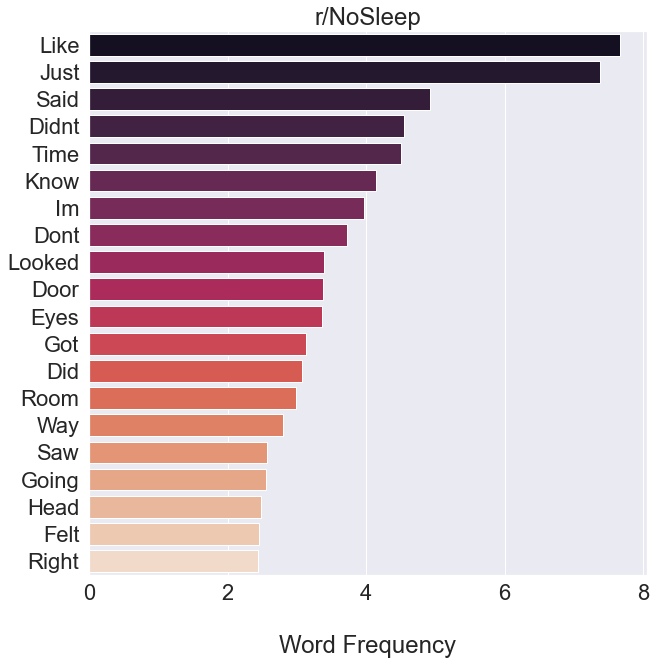

In [35]:
plt.figure(figsize = (10,10))

sns.set(font_scale = 2)
plt.xlabel('\nWord Frequency')
sns.barplot(slp[:20], slp.index.str.title()[:20], palette = 'rocket').set_title('r/NoSleep');

In [36]:
cv3 = CountVectorizer(stop_words= 'english',
                        max_df=.98,
                        max_features = 3000,
                        min_df = 5,
                        ngram_range = (1,2))

tale_vec = cv3.fit_transform(tale['fulltext'])
vec_tale = pd.DataFrame(tale_vec.toarray(), columns = cv3.get_feature_names())

In [37]:
work = vec_tale.mean().sort_values(ascending = False)

r/IDontWorkHereLady contains words that deal with retail, stores, and work. They are more concrete in nature. We did not expect to get this many words that are this indicative of the difference between the subreddits. We believed that more emotional wording would be used that would evoke similar feelings of despair in r/IDontWorkHereLady. We were wrong in our assumptions.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


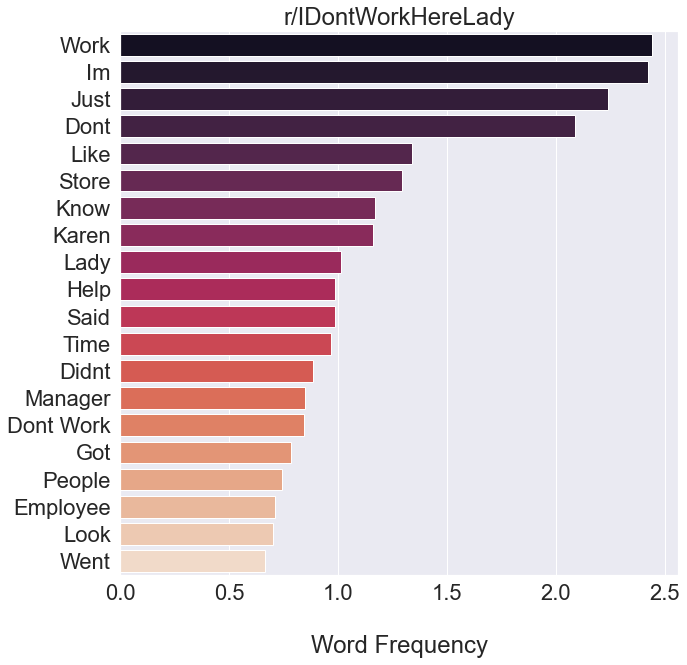

In [38]:
plt.figure(figsize = (10,10))

sns.set(font_scale = 2)
plt.xlabel('\nWord Frequency')
sns.barplot(work[:20], work.index.str.title()[:20], palette = 'rocket').set_title('r/IDontWorkHereLady');

In [43]:
sleep_notable = vec_sleep.mean() - vec_tale.mean()
sleep_notable = sleep_notable.dropna().sort_values(ascending = False)

We found the top list of words in r/NoSleep compared to r/IDontWorkHereLady by subtracting the mean count of r/NoSleep from r/IDontWorkHereLady. The chart below shows again, the more abstract nature of wordingin r/NoSleep.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


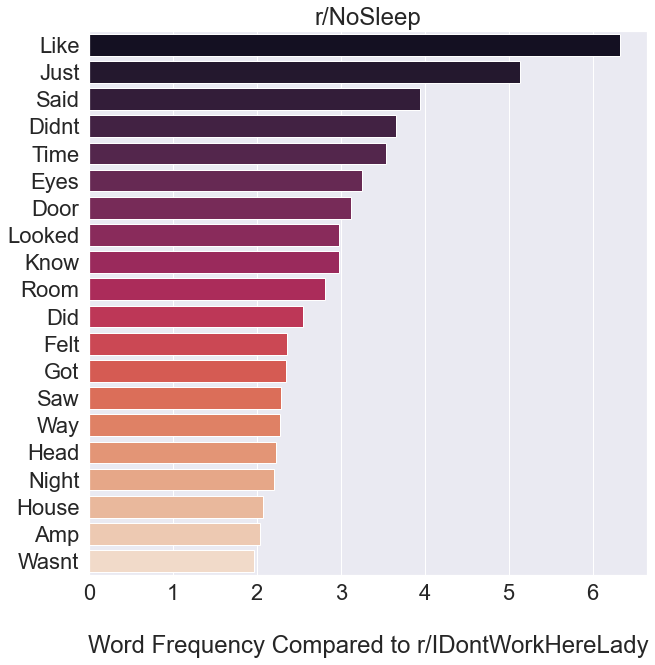

In [44]:
plt.figure(figsize = (10,10))

sns.set(font_scale = 2)
plt.xlabel('\nWord Frequency Compared to r/IDontWorkHereLady')
sns.barplot(sleep_notable[:20], sleep_notable.index.str.title()[:20], palette = 'rocket').set_title('r/NoSleep');

In [39]:
tale_notable = vec_tale.mean() - vec_sleep.mean()
tale_notable = tale_notable.dropna().sort_values(ascending = False)

r/IDontWorkHereLady shows an even greater distinction in words related to stores and retail work. We now imagine that the model may score higher in accuracy as the subreddits are actually quite distinct.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


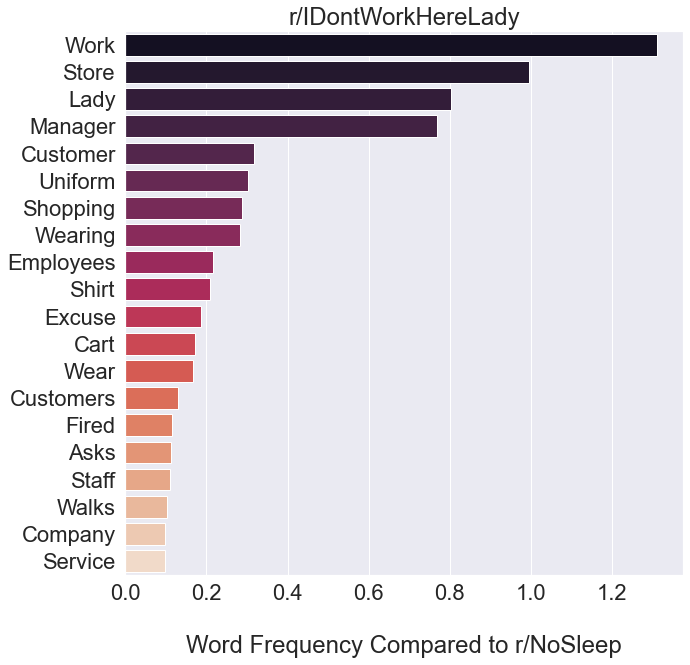

In [40]:
plt.figure(figsize = (10,10))

sns.set(font_scale = 2)
plt.xlabel('\nWord Frequency Compared to r/NoSleep')
sns.barplot(tale_notable[:20], tale_notable.index.str.title()[:20], palette = 'rocket').set_title('r/IDontWorkHereLady');


## Modeling

In [45]:
# empty dataframe to store modeling scores later on
table = pd.DataFrame()

We begin taking 10% sample of our overall cleaned data as we were worried about the resources involved in computation and processing. Originally 5% was tested. We changed it to 10% since we wanted to be certain that the modeling numbers were correct and indeed they were.
Our baseline is an even 50% accuracy score as we wanted our modeling to at least outperform random chance.

In [46]:
# sampling idea credit: https://github.com/gwenrathgeber/subreddit_text_classification/blob/master/code/modeling_and_analysis.ipynb
sample = both.sample(frac=.10, random_state=42)

X = sample['fulltext']
y = sample['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [47]:
# Baseline accuracy is exactly 50%, as the Both dataframe contains the same amount of posts from both subreddits
sample.shape, sample.shape

((1020, 2), (1020, 2))

## Grid Searched Multinomial Bayes

Right off the bat, we started with a Naive Bayes as we knew that model generally did well with smaller data. And, if it did well with the sample, it would certainly do well with even more data. We did not expect for it do this well with a 98.8% accuracy score. Accuracy is the metric we are aiming for, as we are only concerned with pure predictive power.

In [48]:
pipe_tvec1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB() )
])

pipe_tvec_params1 = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

gs1 = GridSearchCV(pipe_tvec1, pipe_tvec_params1, cv = 5)

In [49]:
%%time
gs1.fit(X_train, y_train)

Wall time: 1min 58s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [50]:
gs1.score(X_train, y_train), gs1.score(X_test, y_test)

(0.9934640522875817, 0.9882352941176471)

In [51]:
# adding scores to our table of overall models
table.loc['Grid_Naive_Bayes', 'Training Score'] = gs1.score(X_train, y_train)
table.loc['Grid_Naive_Bayes', 'Testing Score'] = gs1.score(X_test, y_test)

Our confusion matrix shows that it mislabeled an r/IDontWorkHereLady post as an r/NoSleep post. Unfortunately we were unable to figure out how to obtain that post.

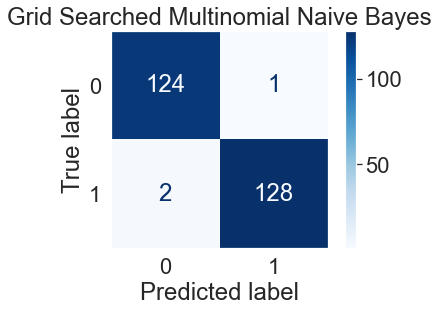

In [53]:
plot_confusion_matrix(gs1, X_test, y_test, cmap='Blues');
plt.title('Grid Searched Multinomial Naive Bayes')
plt.grid(False)

## Randomized Search Multinomial Naive Bayes

We wanted to see if the searching algorith would result in a different score but resulted in the same.

In [54]:
rs_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB() )
])

rs_params = pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

svc_rs = RandomizedSearchCV(estimator = rs_pipe,
                     param_distributions = rs_params,
                     scoring = 'accuracy',
                     n_iter = 2000,
                     n_jobs = -2,
                     cv = 5,
                     verbose = 1)

In [55]:
svc_rs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 16 is smaller than n_iter=2000. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('nb', MultinomialNB())]),
                   n_iter=2000, n_jobs=-2,
                   param_distributions={'tvec__max_features': [2000, 3000, 4000,
                                                               5000],
                                        'tvec__ngram_range': [(1, 1), (1, 2)],
                                        'tvec__stop_words': [None, 'english']},
                   scoring='accuracy', verbose=1)

In [56]:
svc_rs.score(X_train, y_train), svc_rs.score(X_test, y_test)

(0.9934640522875817, 0.9882352941176471)

In [57]:
# adding scores to our table of overall models
table.loc['Rand_Naive_Bayes', 'Training Score'] = svc_rs.score(X_train, y_train)
table.loc['Rand_Naive_Bayes', 'Testing Score'] = svc_rs.score(X_test, y_test)

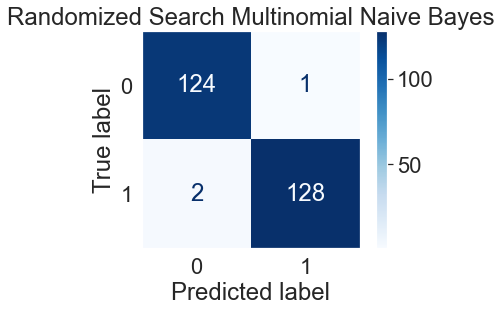

In [58]:
plot_confusion_matrix(svc_rs, X_test, y_test, cmap='Blues');
plt.title('Randomized Search Multinomial Naive Bayes')
plt.grid(False)

## Ridge Logistic Regression

Next was a Ridge Regression. As is typical with a Ridge, our model is overfit but it did quite well in testing accuracy. Our Naive Bayes is still better since it is not as overfit.

In [60]:
pipe_logreg = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(penalty = 'none') )
])

pipe_logreg_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

gslog = GridSearchCV(pipe_logreg, pipe_logreg_params, cv = 5)

In [61]:
%%time
gslog.fit(X_train, y_train)

Wall time: 1min 59s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg',
                                        LogisticRegression(penalty='none'))]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [62]:
gslog.score(X_train, y_train), gslog.score(X_test, y_test)

(1.0, 0.984313725490196)

In [63]:
# adding scores to our table of overall models
table.loc['Logistic_Regression', 'Training Score'] = gslog.score(X_train, y_train)
table.loc['Logistic_Regression', 'Testing Score'] = gslog.score(X_test, y_test)

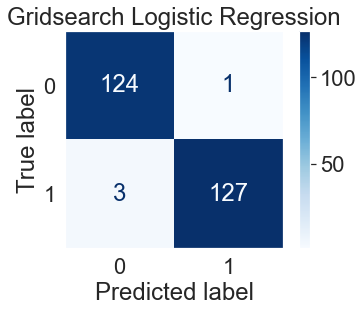

In [64]:
plot_confusion_matrix(gslog, X_test, y_test, cmap='Blues');
plt.title('Gridsearch Logistic Regression')
plt.grid(False)

## Lasso

With the Lasso, we hoped it hone in on the overfit aspect of our Ridge because of its regularizing features. However, we ended up scoring lower on our testing data. This may in part be due to scaling.

In [65]:
pipe_lasso = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ss', StandardScaler(with_mean = False)),
    ('lasso', LogisticRegression(penalty = 'l1', solver = 'liblinear') )
])

pipe_lasso_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

gslasso = GridSearchCV(pipe_lasso, pipe_lasso_params, cv = 5)

In [67]:
gslasso.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('lasso',
                                        LogisticRegression(penalty='l1',
                                                           solver='liblinear'))]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [68]:
gslasso.score(X_train, y_train), gslasso.score(X_test, y_test)

(1.0, 0.9725490196078431)

In [69]:
# adding scores to our table of overall models
table.loc['Lasso', 'Training Score'] = gslasso.score(X_train, y_train)
table.loc['Lasso', 'Testing Score'] = gslasso.score(X_test, y_test)

## TFIDF Random Forest Classifier

We wanted to try a Random Forest Classifier just for fun even though we know the potential for overfitting. Unsurprisingly, it overfit and performed as well as our Lasso.

In [79]:
pipe_forest = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier() )
])

pipe_forest_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

gs2 = GridSearchCV(pipe_forest, pipe_forest_params, cv = 5)

In [80]:
%%time
gs2.fit(X_train, y_train)

Wall time: 2min 30s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [81]:
gs2.score(X_train, y_train), gs2.score(X_test, y_test)

(1.0, 0.9764705882352941)

In [82]:
# adding scores to our table of overall models
table.loc['TFIDF_Random_Forest', 'Training Score'] = gs2.score(X_train, y_train)
table.loc['TFIDF_Random_Forest', 'Testing Score'] = gs2.score(X_test, y_test)

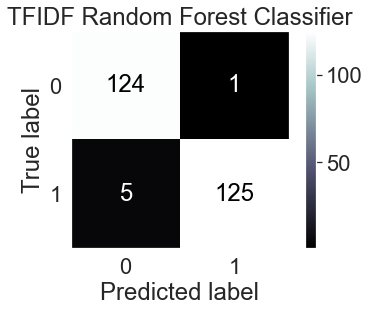

In [83]:
plot_confusion_matrix(gs2, X_test, y_test, cmap='bone');
plt.title('TFIDF Random Forest Classifier')
plt.grid(False)

## Count Vectorized Random Forest Classifier

We were curious about the effect of Count Vectorizing versus TFIDF and wanted to see if there was any difference. The Count Vectorized model did worse in testing accuracy but this could be due to the random nature of the Random Forest Classifier and not the Count Vectorizer. More would have to be done to determine whether or not there is a substantive difference. But, overall, our Naive Bayes performed the best.

In [84]:
cvec = CountVectorizer(stop_words = 'english')

X_train_cv = cvec.fit_transform(X_train)
X_test_cv = cvec.transform(X_test)

In [85]:
rfc = RandomForestClassifier()

rfc.fit(X_train_cv, y_train)

RandomForestClassifier()

In [86]:
rfc.score(X_train_cv, y_train), rfc.score(X_test_cv, y_test)

(1.0, 0.9529411764705882)

In [87]:
# adding scores to our table of overall models
table.loc['CVec_Random_Forest', 'Training Score'] = rfc.score(X_train_cv, y_train)
table.loc['CVec_Random_Forest', 'Testing Score'] = rfc.score(X_test_cv, y_test)

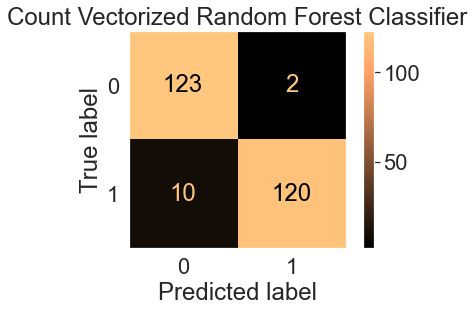

In [88]:
plot_confusion_matrix(rfc, X_test_cv, y_test, cmap='copper');
plt.title('Count Vectorized Random Forest Classifier')
plt.grid(False)

## Conclusion

In [89]:
table

,Training Score,Testing Score
Grid_Naive_Bayes,0.993464,0.988235
Rand_Naive_Bayes,0.993464,0.988235
Logistic_Regression,1.000000,0.984314
Lasso,1.000000,0.972549
TFIDF_Random_Forest,1.000000,0.976471
CVec_Random_Forest,1.000000,0.952941


Our Multinomial Naive Bayes models, with an accuracy score of 98.8%, were the best at predicting where a post came from. They were the least overfit, albeit by less than a single percent, than the other models we tested. We believe accuracy can be improved, but would take a considerable amount of time and resources for a very miniscule increase in percentage. A company could use our model to automatically identify which subreddit a post came from, but there are other cost-effective ways that do not involve machine learning.